In [57]:
DATASET_DIR = "/content/drive/MyDrive/Resources/animal_dataset"
CLASS_ORDER = ["cat", "dog", "panda"]
IMG_SIZE = (32, 32)
RANDOM_SEED = 42
KS = list(range(1, 26, 2))
N_FOLDS = 5
OUTPUT_DIR = "/content/drive/MyDrive/Resources/animal_dataset"
VERBOSE = True

In [58]:
import os
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def log(*args):
    if VERBOSE:
        print(*args)

def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)

set_seeds(RANDOM_SEED)

In [59]:
def load_images_from_folders(parent_dir, class_names, img_size=(32,32), max_per_class=None):

    X_list, y_list, paths = [], [], []
    parent = Path(parent_dir)

    # Define allowed extensions once
    valid_exts = {'.jpg', '.jpeg', '.png', '.bmp'}

    for idx, cname in enumerate(class_names):
        cdir = parent / cname

        # Extra safety: skip if subfolder doesn't exist
        if not cdir.exists() or not cdir.is_dir():
            log(f"Warning: class folder not found or not a directory -> {cdir}")
            continue

        count_for_class = 0

        # Iterate over all files and filter by extension on the fly
        for f in sorted(cdir.iterdir()):
            if f.suffix.lower() not in valid_exts:
                continue

            # Respect max_per_class using a counter instead of slicing list
            if max_per_class is not None and count_for_class >= max_per_class:
                break

            try:
                img = io.imread(str(f))

                # Handle different channel cases in a slightly different order
                if img.ndim == 4:
                    # e.g. RGBA
                    img = color.rgba2rgb(img)
                    img = color.rgb2gray(img)
                elif img.ndim == 3:
                    # RGB
                    img = color.rgb2gray(img)
                elif img.ndim == 2:
                    # already grayscale
                    pass
                else:
                    # Unexpected shape, skip this image
                    log("Skipping unsupported image shape", f, img.shape)
                    continue

                # Resize and flatten
                img = transform.resize(img, img_size, anti_aliasing=True)
                img = img.astype(np.float32).ravel()

                X_list.append(img)
                y_list.append(idx)
                paths.append(str(f))
                count_for_class += 1

            except Exception as e:
                log("Failed to load", f, e)

    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list)

    return X, y, paths, class_names


In [60]:
def evaluate_knn_cv(X, y, ks, metric, n_folds=5, seed=42):

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

    accs = {k: [] for k in ks}

    def compute_dist(a, b):
        if metric == "euclidean" or metric == "l2":
            return np.sqrt(np.sum((a - b) ** 2, axis=1))
        elif metric == "manhattan" or metric == "l1":
            return np.sum(np.abs(a - b), axis=1)
        else:
            raise ValueError("Unsupported metric:", metric)

    for train_idx, val_idx in kf.split(X):
        Xtr, Xval = X[train_idx], X[val_idx]
        ytr, yval = y[train_idx], y[val_idx]

        for k in ks:

            preds = []

            for x in Xval:

                dists = compute_dist(Xtr, x)

                knn_idx = np.argsort(dists)[:k]

                knn_labels = ytr[knn_idx]
                pred = np.bincount(knn_labels).argmax()

                preds.append(pred)

            preds = np.array(preds)

            accs[k].append(accuracy_score(yval, preds))


    mean_acc = {k: np.mean(accs[k]) for k in ks}

    return accs, mean_acc


In [61]:
def plot_results(ks, mean_e, mean_m, out_path):
    plt.figure(figsize=(8,5))
    plt.plot(ks, [mean_e[k] for k in ks], marker="o", label="Euclidean (L2)")
    plt.plot(ks, [mean_m[k] for k in ks], marker="s", label="Manhattan (L1)")
    plt.xlabel("K")
    plt.ylabel("Accuracy (5-fold)")
    plt.title("KNN Accuracy: L1 vs L2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()
    log("Saved plot to:", out_path)

In [62]:
def visualize_top_examples(X, y, paths, class_names, k, metric, out_path):
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
    knn.fit(X, y)

    idxs = list(range(5))
    preds = knn.predict(X[idxs])

    plt.figure(figsize=(15,3))
    for i, idx in enumerate(idxs):
        img = X[idx].reshape(IMG_SIZE)
        plt.subplot(1,5,i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"P:{class_names[preds[i]]}\nT:{class_names[y[idx]]}")
        plt.axis('off')

    plt.suptitle(f"Top-5 Predictions (metric={metric}, k={k})")
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()
    log("Saved visualization:", out_path)

Loading dataset...
Dataset loaded: (300, 1024) labels: (300,)

Running Euclidean (L2) cross-validation...

Running Manhattan (L1) cross-validation...

Best K (L2): 15 -> 0.43667
Best K (L1): 13 -> 0.46667


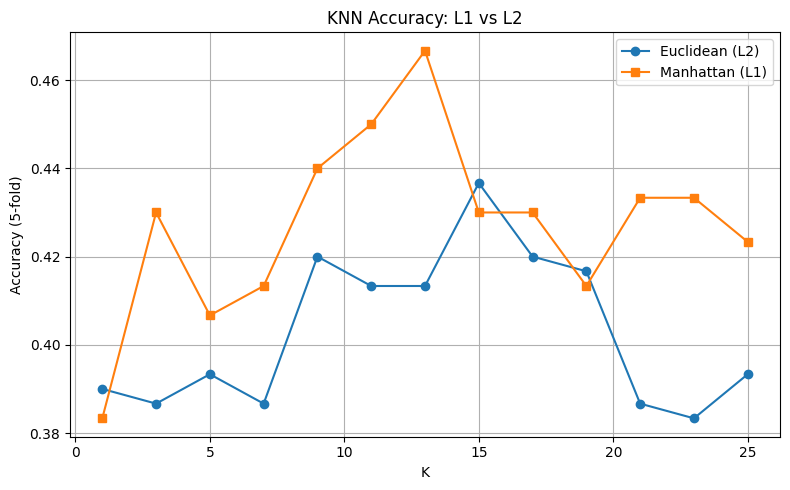

Saved plot to: /content/drive/MyDrive/Resources/animal_dataset/knn_accuracy.png


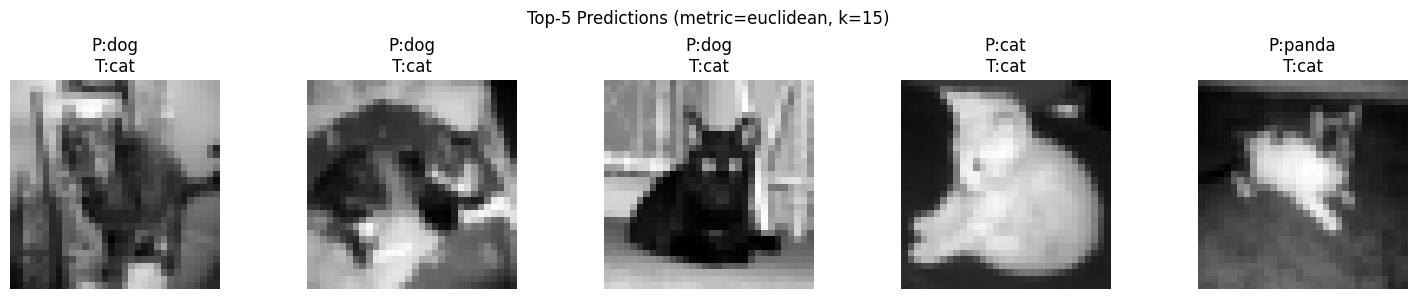

Saved visualization: /content/drive/MyDrive/Resources/animal_dataset/top5_euclidean.png


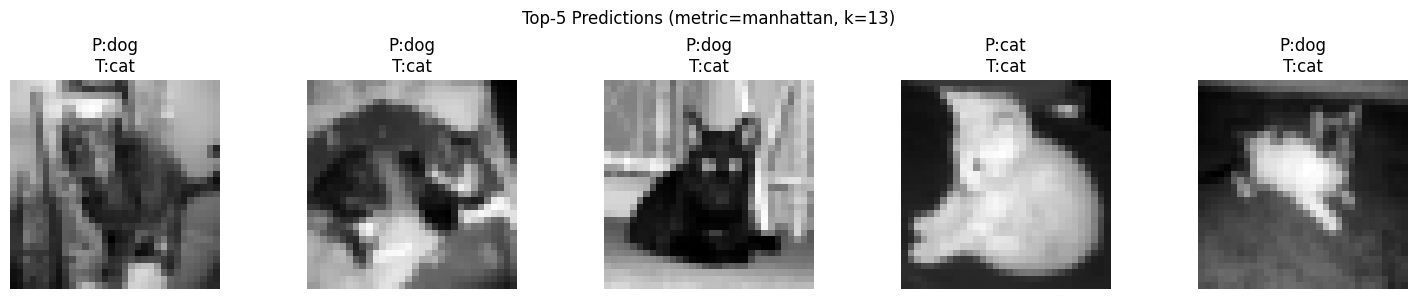

Saved visualization: /content/drive/MyDrive/Resources/animal_dataset/top5_manhattan.png

DONE. All outputs saved to: /content/drive/MyDrive/Resources/animal_dataset


In [63]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

log("Loading dataset...")
X, y, paths, classes = load_images_from_folders(
    DATASET_DIR,
    CLASS_ORDER,
    IMG_SIZE,
    max_per_class=500
)

log("Dataset loaded:", X.shape, "labels:", y.shape)

log("\nRunning Euclidean (L2) cross-validation...")
accs_e, mean_e = evaluate_knn_cv(X, y, KS, metric="euclidean", n_folds=N_FOLDS)

log("\nRunning Manhattan (L1) cross-validation...")
accs_m, mean_m = evaluate_knn_cv(X, y, KS, metric="manhattan", n_folds=N_FOLDS)

best_k_e = max(mean_e, key=mean_e.get)
best_k_m = max(mean_m, key=mean_m.get)

log(f"\nBest K (L2): {best_k_e} -> {mean_e[best_k_e]:.5f}")
log(f"Best K (L1): {best_k_m} -> {mean_m[best_k_m]:.5f}")

plot_path = f"{OUTPUT_DIR}/knn_accuracy.png"
plot_results(KS, mean_e, mean_m, plot_path)

vis_e = f"{OUTPUT_DIR}/top5_euclidean.png"
vis_m = f"{OUTPUT_DIR}/top5_manhattan.png"

visualize_top_examples(X, y, paths, classes, best_k_e, "euclidean", vis_e)
visualize_top_examples(X, y, paths, classes, best_k_m, "manhattan", vis_m)

log("\nDONE. All outputs saved to:", OUTPUT_DIR)